In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hydrant.topology.geom as gm
# import hydrant.mizuRoute.mizuRoute as mz
import subprocess
import os
from   shapely.geometry import Point

In [2]:
# inputs
path_out = './output/'
pfafs = ['71','78'] # 71 Saskatchewan, 78 Colombia
riv_path = '/project/def-kshook/temp/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'
cat_path = '/project/def-kshook/temp/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'
cst_path = '/project/def-kshook/temp/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/coastal_hillslopes/'
riv_file_template = 'riv_pfaf_*_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'
cat_file_template = 'cat_pfaf_*_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'
cst_file_template = 'hillslope_*_clean.shp'

In [3]:
if not os.path.isdir(path_out):
    os.makedirs(path_out)

# Load and append the pfaf

In [4]:
riv, cat = gm.merit_read_file (pfafs,
                               riv_path,
                               riv_file_template,
                               cat_path,
                               cat_file_template,
                               path_cst = cst_path,
                               cst_file_template = cst_file_template)

/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


# prepare the network topology

In [5]:
riv, cat = gm.prepare_ntopo(riv=riv,\
                            riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                            cat=cat,\
                            cat_cols={'id':'COMID', 'hillslope':'hillslope', 'area' :'unitarea'},\
                            network = 'merit')

/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/hydrant/topology/geom.py:490: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river['latitude'] = cat.centroid.y
/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/hydrant/topology/geom.py:491: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river['longitude'] = cat.centroid.x


[71000001 71000002 71000003 ... 78038714 78038715 78038716]
[71000065 71000065 71000002 ...    -9999    -9999    -9999]


# Example-1 From Fraser River

In [6]:
# set the case name
prefix = 'Fraser_merit_'

In [7]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'COMID'},\
                                       riv=riv,\
                                       riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                                       outlet_id=[78011886]) # segment that is aimed to make the subbasin for


[78002623 78002618 78002559 ... 78012456 78011887 78011886]
[78002480 78002480 78003234 ... 78011886 78011886    -9999]


<AxesSubplot:>

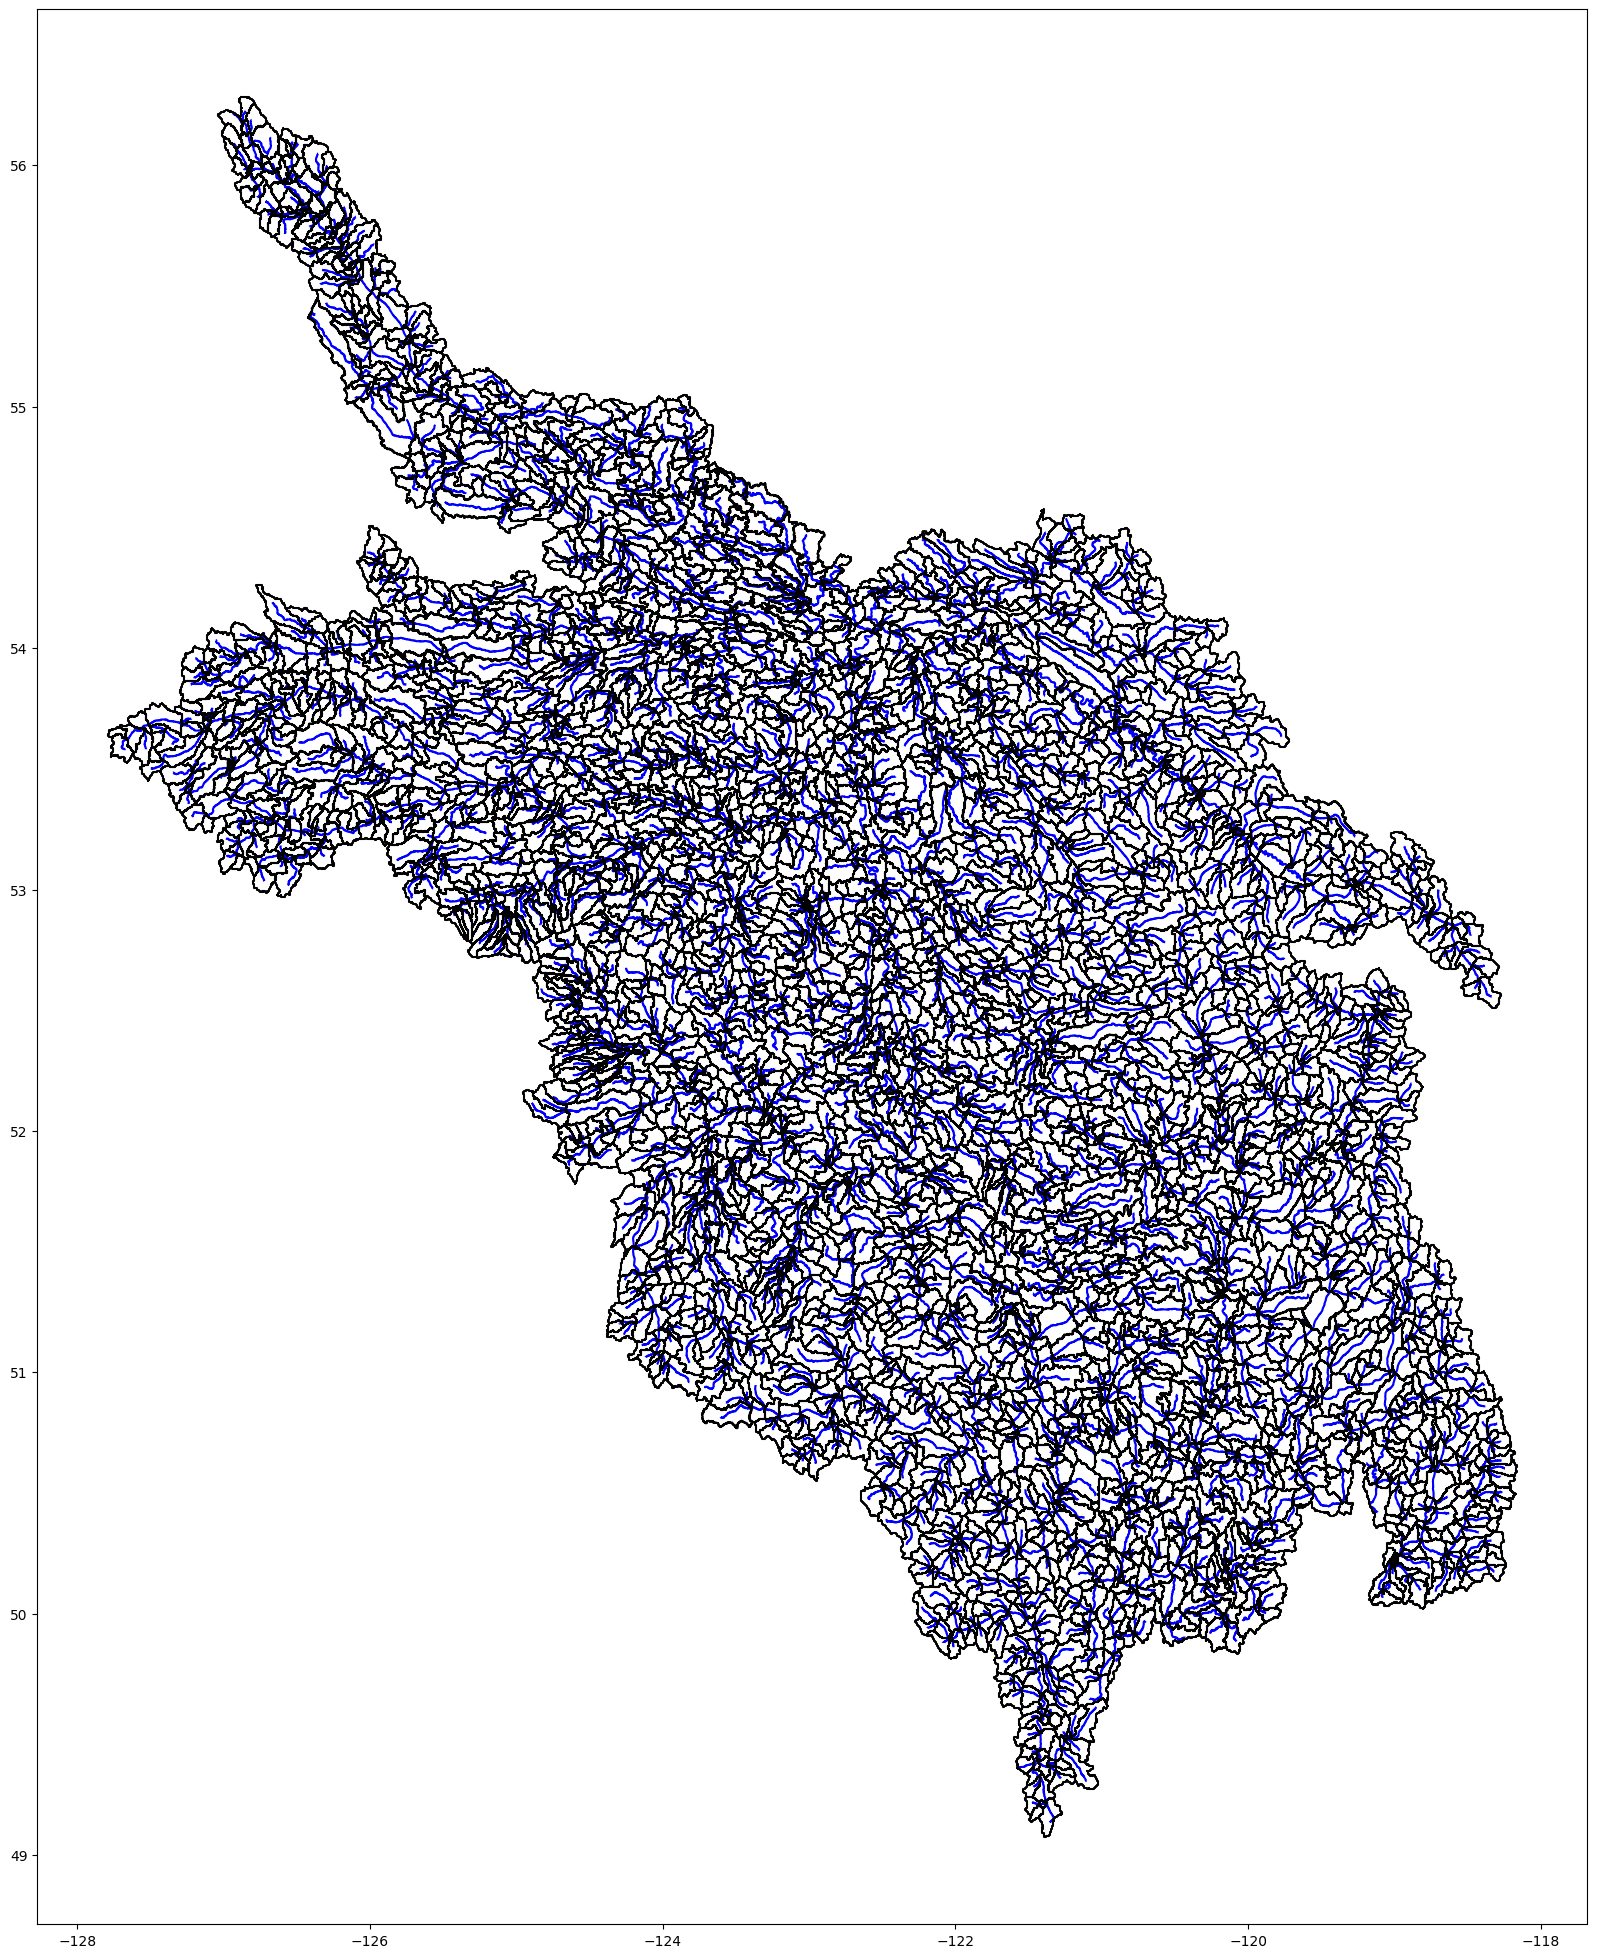

In [8]:
fig, ax = plt.subplots(figsize=(20,30))
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')

In [9]:
xr_ntopo = gm.create_xr_ntopo(riv_slice,
                              cat_slice,
                              network = 'merit')
xr_ntopo

<xarray.Dataset>
Dimensions:     (n: 4554)
Coordinates:
  * n           (n) int64 0 1 2 3 4 5 6 7 ... 4547 4548 4549 4550 4551 4552 4553
Data variables: (12/22)
    COMID       (n) int64 78002549 78002559 78002618 ... 78012456 78011886
    length      (n) float64 892.7 3.696e+03 8.147e+03 ... 8.262e+03 9.603e+03
    lengthdir   (n) float64 0.6276 3.425 6.077 5.307 ... 5.673 3.063 5.719 8.264
    sinuosity   (n) float64 1.422 1.079 1.341 1.235 ... 1.244 1.248 1.444 1.162
    slope       (n) float64 0.01643 0.02323 0.01401 ... 0.03047 0.0003948
    uparea      (n) float64 2.769e+07 5.325e+07 ... 3.215e+08 2.172e+11
    ...          ...
    unitarea    (n) float64 2.769e+07 5.325e+07 ... 3.241e+07 4.993e+07
    latitude    (n) float64 56.07 56.12 56.18 56.24 ... 49.28 49.39 49.33 49.38
    longitude   (n) float64 -127.0 -126.9 -126.9 -126.8 ... -121.5 -121.5 -121.5
    width       (n) float64 6.262 8.297 8.842 7.56 ... 7.288 466.6 18.93 467.0
    Rank        (n) int64 1 2 3 4 5 6 7 8 ... 4548 4549 4550 4551 4552 4553 4554
    Rank_Next   (n) int64 5 5 9 9 11 11 12 ... 4552 4552 4553 4553 4554 4554 0

## save

In [10]:
cat_slice.to_file(path_out+prefix+'cat.shp')
riv_slice.to_file(path_out+prefix+'riv.shp')
xr_ntopo.to_netcdf(path_out+prefix+'ntopo.nc')
ll

NameError: name 'll' is not defined

# Example-2 From basins of identified pfafs that intersect with Alberta and Saskatchewan

In [ ]:
# set the case name
prefix = 'ALSASK_merit_'

In [ ]:
# load the info and the provience
trg_shp = gpd.read_file('./data/province/provinces.shp')
sel_pr = ['Alberta','Saskatchewan']
# subsetting `provinces` variable
trg_provinces = trg_shp.loc[trg_shp.PRENAME.isin(sel_pr)].copy().to_crs(epsg=4326)

In [ ]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'COMID'},\
                                       riv=riv,\
                                       riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                                       shapefile=trg_provinces)

In [ ]:
fig, ax = plt.subplots(figsize=(20,30))
trg_provinces.boundary.plot(ax=ax, color='k')
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')

In [ ]:
mz_ntopo = mz.create_nc_ntopo(riv_slice,
                              cat_slice,
                              network = 'merit')
mz_ntopo

In [ ]:
cat_slice.to_file(path_out+prefix+'cat.shp')
riv_slice.to_file(path_out+prefix+'riv.shp')
mz_ntopo.to_netcdf(path_out+prefix+'mizuRoute_ntopo.nc')

# Example-3 From basins of identified pfafs that intersect with target stations in Alberta

In [ ]:
# set the case name
prefix = 'stations_merit_'

In [ ]:
data = {
    'Station ID': ['05BE004', '05BH004', '05BL004', '05CC002'],
    'seg ID': [71028039, 71027942, 71034975, 71022153],
    'Station name': [
        'BOW RIVER NEAR SEEBE',
        'BOW RIVER AT CALGARY',
        'HIGHWOOD RIVER BELOW LITTLE BOW CANAL',
        'RED DEER RIVER AT RED DEER'
    ],
    'up': [0, 0, 0, 0],
    'X': [-115.03,-114.05,-113.86,-113.82],
    'Y': [51.11,    51.05,  50.58,  52.27]
}

# Create a DataFrame from the dictionary
stations_seg_id = pd.DataFrame(data)

# Create a points from the dictionary
geometry = [Point(xy) for xy in zip(data['X'], data['Y'])]
stations_points = gpd.GeoDataFrame(data, geometry=geometry, crs='EPSG:4326')

In [ ]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'COMID'},\
                                       riv=riv,\
                                       riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                                       outlet_id=list(stations_seg_id['seg ID']))



In [ ]:
fig, ax = plt.subplots(figsize=(20,30))
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')
stations_points.plot(ax=ax, color='r', markersize=200)


In [ ]:
mz_ntopo = mz.create_nc_ntopo(riv_slice,
                              cat_slice,
                              network = 'merit')
mz_ntopo

In [ ]:
cat_slice.to_file(path_out+prefix+'cat.shp')
riv_slice.to_file(path_out+prefix+'riv.shp')
mz_ntopo.to_netcdf(path_out+prefix+'mizuRoute_ntopo.nc')